# Поиск всех файлов

In [710]:
import glob
import os
import numpy as np
import pandas as pd

path="Content/markup" #Подставить свой путь

files = []
# r=root, d=directories, f = files
print ('Список файлов \n')
for r, d, f in os.walk(path):
    for file in f:
        if file.endswith(('.csv')):
            files.append (os.path.join(r, file))
            #print(os.path.join(r, file))
print (len(files))

Список файлов 

0


In [684]:
#files

In [711]:
import torch.nn as nn

import random
import torch


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

In [712]:
%pip install -q transformers

In [713]:
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from tqdm.notebook import tqdm
from torch.nn.utils.rnn import pad_sequence

import torch
from transformers import AutoTokenizer, AutoModel

# Эталон

In [688]:
from transformers import RobertaForMaskedLM,RobertaTokenizer, pipeline, BertForMaskedLM,BertTokenizer

tokenizers = {}
models = {}
names = ['rubert-tiny', 'ruRoberta-large', 'ruBert-base', 'rubert-tiny2']

tokenizer1 = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model1 = AutoModel.from_pretrained("cointegrated/rubert-tiny")

tokenizer2 = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large')
model2 = RobertaForMaskedLM.from_pretrained('sberbank-ai/ruRoberta-large')

tokenizer3 = BertTokenizer.from_pretrained('sberbank-ai/ruBert-base', do_lower_case=False)
model3 = BertForMaskedLM.from_pretrained('sberbank-ai/ruBert-base')

tokenizer4 = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')
model4 = AutoModel.from_pretrained('cointegrated/rubert-tiny2')

tokenizers = {'rubert-tiny': tokenizer1,
              'ruRoberta-large': tokenizer2,
              'ruBert-base': tokenizer3,
              'rubert-tiny2': tokenizer4}
models = {'rubert-tiny': model1,
          'ruRoberta-large': model2,
          'ruBert-base': model3,
          'rubert-tiny2': model4}

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [689]:
def embed_bert_cls(text, model, tokenizer, model_name):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
        #print (model_output.__dict__)
        #print (model_output)

    if ((model_name == 'rubert-tiny') or (model_name =='rubert-tiny2')):
        embeddings = model_output.last_hidden_state[:, 0, :]
    elif ((model_name == 'ruBert-base') or (model_name == 'ruRoberta-large')):
        embeddings = model_output.logits[:, 0, :]
    else:
        print ('Новая модель, проверить доставание эмбеддингов')
        return 0
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [623]:
names

['rubert-tiny', 'ruRoberta-large', 'ruBert-base', 'rubert-tiny2']

In [624]:
print(embed_bert_cls('привет мир', model1, tokenizer1, model_name = names[0]).shape)

(312,)


In [625]:
names[1]

'ruRoberta-large'

In [533]:
print(embed_bert_cls('привет мир', model2, tokenizer2, model_name = names[1]).shape)

(50265,)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [215]:
print(embed_bert_cls('привет мир', model3, tokenizer3, model_name = names[2]).shape)

(120138,)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [216]:
print(embed_bert_cls('привет мир', model4, tokenizer4, model_name = names[3]).shape)

(312,)


Функция, которая принимает csv-таблицу с оглавлением и сохраняет её в виде текс-вектор, с именем <исходное имя>_<имя модели>

In [599]:
from pathlib import Path
def toc_process(model, tokenizer, file = "Content/Etalon.csv",  encoding='cp1251', model_name='tiny_bert', dirr = 'markup'):
    filemane = file.split('/')[-1].split('.')[0]
    csv_name = "Content/"+dirr+"/vectors/" + filemane + '_'+ model_name + '.csv'
    s = Path(csv_name)
    if not s.exists():
        my_cols = ['№', 'Текст']
        df = pd.read_csv(file,
                        sep=";",
                        encoding=encoding,
                        names=my_cols,
                        header=None,
                        engine="python")
        
        df = df.drop('№',axis = 1)
        df['Текст'] = df['Текст'].str.lower()

        set_random_seed(42)

        features_po_tiny = []
        for index, row in df.iterrows():
            emb = embed_bert_cls(row["Текст"], model, tokenizer, model_name)
            features_po_tiny.append(emb)

        df = pd.DataFrame((np.hstack([df, np.array(features_po_tiny)])))
        for i in range(len(df.index)):
            #df.loc[i, 'vec'] = np.array(df.loc[i, 1:(len(df.columns)-2):1])
            df.loc[i, 'vec'] = ','.join (map(str, df.loc[i, 1:]))

        df_fin = pd.DataFrame(np.vstack([df[0], df['vec']]).T, columns = ['Текст', 'Вектор'])


        df_fin.to_csv(csv_name, index=False)
        return df_fin
    else:
        print ('Exists:', csv_name)

In [600]:
names

['rubert-tiny', 'ruRoberta-large', 'ruBert-base', 'rubert-tiny2']

In [601]:
for name in names:
    model = models[name]
    tokenizer = tokenizers[name]

    toc_process(model = model, tokenizer = tokenizer, file = "Content/markup/Etalon.csv", encoding='utf-8', model_name=name)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


## Обработка остальных файлов. !!Со столбцом разметки!!

In [627]:
from pathlib import Path
def toc_process_strats(model, tokenizer, file = "Amursk.csv",  encoding='utf-8', model_name='tiny_bert', dirr = 'markup'):
    filemane = file.split('/')[-1].split('.')[0]
    csv_name = "Content/"+ dirr + "/vectors/" + filemane + '_'+ model_name + '.csv'
    s = Path(csv_name)
    if not s.exists():
        my_cols = ['Текст', 'Эталон']
        df = pd.read_csv(file,
                        sep=";",
                        encoding='utf-8',
                        names=my_cols,
                        header=None,
                        engine="python")
        print (df.head(2))
        if (df['Текст'][0] == 'NaN'):
            df = df.drop([1,2],axis = 1)
            df = df.set_axis(my_cols, axis=1)
        try:
            df['Текст'] = df['Текст'].str.lower()

            set_random_seed(42)
            #df['Текст'] = df['Текст'].str.lower()


            print (1)
            features_po_tiny = []
            for index, row in df.iterrows():
                emb = embed_bert_cls(row["Текст"], model, tokenizer, model_name)
                features_po_tiny.append(emb)

            df = pd.DataFrame((np.hstack([df, np.array(features_po_tiny)])))
            for i in range(len(df.index)):
                #df.loc[i, 'vec'] = np.array(df.loc[i, 2:(len(df.columns)-2):1])
                df.loc[i, 'vec'] = ','.join (map(str, df.loc[i, 2:])) #Пропускаем первые 2 столбца с текстом и разметкой
            df_fin = pd.DataFrame(np.vstack([df[0], df[1], df['vec']]).T, columns=['Текст', 'Эталон', 'Вектор'])

            #print (df_fin.columns)
            df_fin.to_csv(csv_name, index=False)
            print (csv_name)

            return df_fin
        except AttributeError:
            print ('Error:', csv_name)
            
        finally:
            print ('Error:', csv_name)
    else:
        print ('Exists:', csv_name)

In [606]:
file = 'Content/markup/Buryatia.csv'
my_cols = ['Текст', 'Эталон']
df = pd.read_csv(file,
                        sep=";",
                        encoding='utf-8',
                        names=my_cols,
                        header=None,
                        engine="python")
df['Текст'] = df['Текст'].str.lower()
df.head(2)

,Текст,Эталон
0,1. общие положения,1
1,2. оценка достигнутых целей социально-экономич...,2


In [583]:
#files

In [628]:
matching = [s for s in files if "Etalon" in s]
matching

['Content/markup/Etalon.csv',
 'Content/markup/vectors/Etalon_rubert-tiny.csv',
 'Content/markup/vectors/Etalon_ruRoberta-large.csv',
 'Content/markup/vectors/Etalon_ruBert-base.csv',
 'Content/markup/vectors/Etalon_rubert-tiny2.csv']

In [631]:
files = [s for s in files if "Etalon" not in s]
files = [s for s in files if "vectors" not in s]
files

['Content/markup/Volgograd.csv',
 'Content/markup/Voronezh.csv',
 'Content/markup/Yakutia.csv',
 'Content/markup/Tyva.csv',
 'Content/markup/Udmurt.csv',
 'Content/markup/Vologda.csv',
 'Content/markup/Ulyanovsk.csv',
 'Content/markup/Yaroslavl.csv',
 'Content/markup/Yamalo-Nenets.csv',
 'Content/markup/Adygeya.csv',
 'Content/markup/Altai Resp.csv',
 'Content/markup/Altai.csv',
 'Content/markup/Amur.csv',
 'Content/markup/Buryatia.csv',
 'Content/markup/Astrakhan.csv',
 'Content/markup/Bryansk.csv',
 'Content/markup/Bashkortastan.csv',
 'Content/markup/Belgorod.csv',
 'Content/markup/Vladimir.csv',
 'Content/markup/Arkhangelsk.csv']

In [632]:
#!c1.32
for name in names:
    print (name)
    model = models[name]
    tokenizer = tokenizers[name]
    for strat in files:
        toc_process_strats(model = model, tokenizer = tokenizer, file = strat, encoding='utf-8', model_name=name)

rubert-tiny
Exists: Content/markup/vectors/Volgograd_rubert-tiny.csv
Exists: Content/markup/vectors/Voronezh_rubert-tiny.csv
Exists: Content/markup/vectors/Yakutia_rubert-tiny.csv
Exists: Content/markup/vectors/Tyva_rubert-tiny.csv
Exists: Content/markup/vectors/Udmurt_rubert-tiny.csv
Exists: Content/markup/vectors/Vologda_rubert-tiny.csv
Exists: Content/markup/vectors/Ulyanovsk_rubert-tiny.csv
Exists: Content/markup/vectors/Yaroslavl_rubert-tiny.csv
Exists: Content/markup/vectors/Yamalo-Nenets_rubert-tiny.csv
Exists: Content/markup/vectors/Adygeya_rubert-tiny.csv
Exists: Content/markup/vectors/Altai Resp_rubert-tiny.csv
Exists: Content/markup/vectors/Altai_rubert-tiny.csv
Exists: Content/markup/vectors/Amur_rubert-tiny.csv
                                               Текст  Эталон
0                                 1. Общие положения       1
1  2. Оценка достигнутых целей социально-экономич...       2
1
Content/markup/vectors/Buryatia_rubert-tiny.csv
Error: Content/markup/vectors/Bur

/home/jupyter/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
#!c1.32


## Сравнение по косинусной мере

In [715]:
import glob
import os


def files_list (path):
    files = []
    print ('Список файлов \n')
    for r, d, f in os.walk(path):
        for file in f:
            if file.endswith(('.csv')):
                files.append (os.path.join(r, file))
                #print(os.path.join(r, file))
    return files


path="Content/markup/vectors" #Подставить свой путь
files_vect = files_list (path)
  

Список файлов 



In [634]:
files_e = [s for s in files_vect if "Etalon" in s]
files_e

['Content/markup/vectors/Etalon_rubert-tiny.csv',
 'Content/markup/vectors/Etalon_ruRoberta-large.csv',
 'Content/markup/vectors/Etalon_ruBert-base.csv',
 'Content/markup/vectors/Etalon_rubert-tiny2.csv']

In [635]:
files_s = [s for s in files_vect if "Etalon" not in s]
files_s

['Content/markup/vectors/Volgograd_rubert-tiny.csv',
 'Content/markup/vectors/Voronezh_rubert-tiny.csv',
 'Content/markup/vectors/Yakutia_rubert-tiny.csv',
 'Content/markup/vectors/Tyva_rubert-tiny.csv',
 'Content/markup/vectors/Udmurt_rubert-tiny.csv',
 'Content/markup/vectors/Vologda_rubert-tiny.csv',
 'Content/markup/vectors/Ulyanovsk_rubert-tiny.csv',
 'Content/markup/vectors/Yaroslavl_rubert-tiny.csv',
 'Content/markup/vectors/Yamalo-Nenets_rubert-tiny.csv',
 'Content/markup/vectors/Adygeya_rubert-tiny.csv',
 'Content/markup/vectors/Altai Resp_rubert-tiny.csv',
 'Content/markup/vectors/Altai_rubert-tiny.csv',
 'Content/markup/vectors/Amur_rubert-tiny.csv',
 'Content/markup/vectors/Bryansk_rubert-tiny.csv',
 'Content/markup/vectors/Bashkortastan_rubert-tiny.csv',
 'Content/markup/vectors/Belgorod_rubert-tiny.csv',
 'Content/markup/vectors/Vladimir_rubert-tiny.csv',
 'Content/markup/vectors/Arkhangelsk_rubert-tiny.csv',
 'Content/markup/vectors/Volgograd_ruRoberta-large.csv',
 'Cont

In [636]:
ethalon = pd.read_csv("Content/markup/vectors/Vladimir_rubert-tiny2.csv", encoding='utf-8', on_bad_lines='skip')
ethalon.head(2)

,Текст,Эталон,Вектор
0,1. анализ и оценка социально-экономических про...,2,"0.038909848779439926,-0.013187400996685028,0.0..."
1,географическое положение.,-1,"0.0213254913687706,-0.03896157816052437,0.0049..."


In [637]:
strat = pd.read_csv("Content/markup/vectors/Etalon_rubert-tiny.csv", encoding='utf-8', on_bad_lines='skip')
strat.head(2)

,Текст,Вектор
0,вводная часть,"-0.052641306072473526,0.00928304623812437,0.01..."
1,оценка достигнутых целей социально-экономиечск...,"0.028239309787750244,-0.021949080750346184,0.0..."


In [638]:
# import required libraries
import numpy as np
from numpy.linalg import norm

# define two lists or array
A = np.array([2,1,2,3,2,9])
B = np.array([3,4,2,4,5,5])

print("A:", A)
print("B:", B)

def cos_sim(A,B):
    return np.dot(A,B)/(norm(A)*norm(B))

print("Cosine Similarity:", cos_sim(A,B))

A: [2 1 2 3 2 9]
B: [3 4 2 4 5 5]
Cosine Similarity: 0.8188504723485274


In [639]:
def makecossim(strat, ethalon):
    filename = strat.split('/')[-1].split('.')[0]
    csv_name = "Content/markup/cossim/" + filename + '_cossim.csv'
    s = Path(csv_name)
    if not s.exists():
        strat =    pd.read_csv (strat, encoding ='utf-8')
        ethalon =  pd.read_csv (ethalon, encoding='utf-8')
        
        for index_s, row_s in strat.iterrows():
            for index_e, row_e in ethalon.iterrows():
                #Делаем вектора из строк. Это костыль, ибо мы сохраняли в pandas вектора в виде строк в 1 ячейку (чтобы не учитывать разные длины векторов)
                list_e = row_e['Вектор'].split(',')
                list_s = row_s['Вектор'].split(',')

                vec_e = list(map(float,list_e))
                vec_s = list(map(float,list_s))

                #косталь - у части строк последнее значение nan
                vec_e = [x for x in vec_e if str(x) != 'nan']
                vec_s = [x for x in vec_s if str(x) != 'nan']

                strat.loc[index_s, row_e['Текст']] = cos_sim(vec_s, vec_e)
        
        df = strat.drop('Вектор',axis = 1)#Тут он нам уже лишний
        df.to_csv(csv_name, index=False)
        print (csv_name)

                
    else:
        print ('Exists:', csv_name)

    

Вот тут нам надо группировать файлы по имени модели

In [640]:
files_dict = {}
for i in names:
    files_dict[i] = [[], []]
    
files_dict

{'rubert-tiny': [[], []],
 'ruRoberta-large': [[], []],
 'ruBert-base': [[], []],
 'rubert-tiny2': [[], []]}

In [641]:
for key in files_dict.keys():
    files_dict[key][0] = [s for s in files_e if key in s][0]
    files_dict[key][1] = [s for s in files_s if key in s]

#Чтобы не попадали тини2 в тини
files_dict['rubert-tiny'][1] = [s for s in files_dict['rubert-tiny'][1] if 'rubert-tiny2' not in s]

print(files_dict['rubert-tiny'][0])
print(files_dict['rubert-tiny'])

Content/markup/vectors/Etalon_rubert-tiny.csv
['Content/markup/vectors/Etalon_rubert-tiny.csv', ['Content/markup/vectors/Volgograd_rubert-tiny.csv', 'Content/markup/vectors/Voronezh_rubert-tiny.csv', 'Content/markup/vectors/Yakutia_rubert-tiny.csv', 'Content/markup/vectors/Tyva_rubert-tiny.csv', 'Content/markup/vectors/Udmurt_rubert-tiny.csv', 'Content/markup/vectors/Vologda_rubert-tiny.csv', 'Content/markup/vectors/Ulyanovsk_rubert-tiny.csv', 'Content/markup/vectors/Yaroslavl_rubert-tiny.csv', 'Content/markup/vectors/Yamalo-Nenets_rubert-tiny.csv', 'Content/markup/vectors/Adygeya_rubert-tiny.csv', 'Content/markup/vectors/Altai Resp_rubert-tiny.csv', 'Content/markup/vectors/Altai_rubert-tiny.csv', 'Content/markup/vectors/Amur_rubert-tiny.csv', 'Content/markup/vectors/Bryansk_rubert-tiny.csv', 'Content/markup/vectors/Bashkortastan_rubert-tiny.csv', 'Content/markup/vectors/Belgorod_rubert-tiny.csv', 'Content/markup/vectors/Vladimir_rubert-tiny.csv', 'Content/markup/vectors/Arkhangelsk_ru

In [642]:
print(len(files_dict[names[0]][1]))
print(len(files_dict[names[1]][1]))
print(len(files_dict[names[2]][1]))
print(len(files_dict[names[3]][1]))

19
19
19
19


In [643]:
#!c1.32
for model_name, strats in files_dict.items():
    print (model_name)
    et = strats[0]
    for st in strats[1]:
        makecossim(strat = st, ethalon = et)


rubert-tiny
Content/markup/cossim/Volgograd_rubert-tiny_cossim.csv
Content/markup/cossim/Voronezh_rubert-tiny_cossim.csv
Content/markup/cossim/Yakutia_rubert-tiny_cossim.csv
Content/markup/cossim/Tyva_rubert-tiny_cossim.csv
Content/markup/cossim/Udmurt_rubert-tiny_cossim.csv
Content/markup/cossim/Vologda_rubert-tiny_cossim.csv
Content/markup/cossim/Ulyanovsk_rubert-tiny_cossim.csv
Content/markup/cossim/Yaroslavl_rubert-tiny_cossim.csv
Content/markup/cossim/Yamalo-Nenets_rubert-tiny_cossim.csv
Content/markup/cossim/Adygeya_rubert-tiny_cossim.csv
Content/markup/cossim/Altai Resp_rubert-tiny_cossim.csv
Content/markup/cossim/Altai_rubert-tiny_cossim.csv
Content/markup/cossim/Amur_rubert-tiny_cossim.csv
Content/markup/cossim/Bryansk_rubert-tiny_cossim.csv
Content/markup/cossim/Bashkortastan_rubert-tiny_cossim.csv
Content/markup/cossim/Belgorod_rubert-tiny_cossim.csv
Content/markup/cossim/Vladimir_rubert-tiny_cossim.csv
Content/markup/cossim/Arkhangelsk_rubert-tiny_cossim.csv
Content/markup/

### Какая-то базовая аналитика


Теперь нужно в табличке пройтись по разным трешхолдам и оценить, какой наилучший.
У нас 10 объектов. Возьмём 8 на обучение и 2 на тест

In [644]:
file = 'Content/markup/cossim/Vladimir_rubert-tiny2_cossim.csv'
cs =    pd.read_csv (file, encoding ='utf-8')
cs.head(2)

,Текст,Эталон,вводная часть,оценка достигнутых целей социально-экономиечского развития,"приоритеты, цели и задачи социально-экономического развития",целевой сценарий социально-экономического развития,основные направления развития человеческого капитала и социальной сферы,основные направления экономического развития,основные направления развития научно-инновационной сферы,основные направления рационального природопользования и обеспечения экологической безопасности,основные направления развития межрегиональных и внешнеэкономических связей,основные направления пространственного развития,сведения о кадровом обеспечении экономики,заключительная часть,"оценка финансовых ресурсов, необходимых для реализации стратегии",сроки и этапы реализации стратегии,пприложение с основными показателями достижения целей социально-экономического развития,приложение с ожидаемыми результатами реализации стратегии,приложение с перечнем крупных инвестиционных проектов,приложение с государственными программи
0,1. анализ и оценка социально-экономических про...,2,0.352316,0.687734,0.646678,0.673853,0.615904,0.598155,0.584261,0.593993,0.628964,0.563283,0.599777,0.334134,0.597736,0.586502,0.658729,0.538018,0.472599,0.448967
1,географическое положение.,-1,0.723446,0.554386,0.564957,0.634500,0.535680,0.632816,0.545485,0.533123,0.512511,0.689647,0.659364,0.678125,0.543130,0.565404,0.537975,0.560270,0.478518,0.592210


In [645]:
row0 = cs.iloc[0,2:].values

In [646]:
len(row0)

18

(array([2., 0., 0., 2., 0., 1., 1., 7., 2., 3.]),
 array([0.3341344944302949, 0.3694944436131581, 0.4048543927960213,
        0.4402143419788845, 0.47557429116174765, 0.5109342403446109,
        0.546294189527474, 0.5816541387103372, 0.6170140878932004,
        0.6523740370760636, 0.6877339862589268], dtype=object),
 <BarContainer object of 10 artists>)

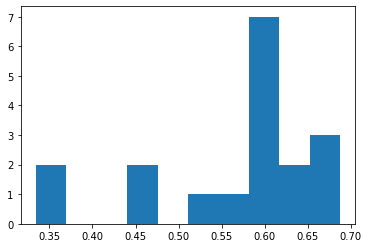

In [647]:

import matplotlib.pyplot as plt
plt.hist(row0)

In [648]:
rows = cs.iloc[:,2:].values

(array([[ 3.,  9.,  5.,  3.,  4.,  3.,  7.,  8.,  2.,  0.],
        [ 0.,  1.,  1.,  8.,  6., 12.,  7.,  6.,  3.,  0.],
        [ 1.,  0.,  3.,  9.,  8.,  9.,  7.,  4.,  1.,  2.],
        [ 0.,  0.,  1.,  3.,  3., 11., 16.,  4.,  3.,  3.],
        [ 1.,  0.,  0.,  9., 12.,  7.,  6.,  8.,  1.,  0.],
        [ 0.,  0.,  1.,  2.,  7., 12., 11.,  7.,  3.,  1.],
        [ 0.,  1.,  1.,  1., 12., 12., 11.,  6.,  0.,  0.],
        [ 1.,  1.,  4.,  9.,  9.,  8.,  8.,  3.,  0.,  1.],
        [ 1.,  0.,  3., 10., 11.,  2., 11.,  6.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  6., 15., 14.,  7.,  1.,  0.],
        [ 0.,  0.,  2.,  2.,  3., 13., 16.,  7.,  1.,  0.],
        [ 7.,  7.,  5.,  5.,  3.,  7.,  7.,  2.,  1.,  0.],
        [ 0.,  1.,  1., 12., 10.,  5.,  8.,  6.,  1.,  0.],
        [ 0.,  1.,  1., 12., 11.,  8.,  1.,  9.,  1.,  0.],
        [ 1.,  0.,  2.,  9., 11.,  7.,  5.,  6.,  1.,  2.],
        [ 0.,  0.,  5., 11., 12.,  6.,  5.,  2.,  3.,  0.],
        [ 0.,  0.,  6.,  8., 17.,  9.,  

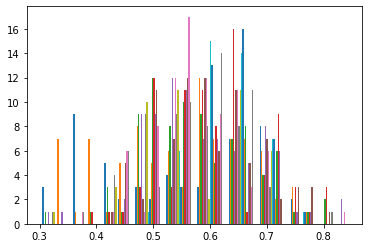

In [649]:
plt.hist(rows)

(array([[ 2., 14., 14., 18., 10.,  1.,  7.,  1.,  1.,  1.],
        [ 0.,  0.,  1., 10., 25., 14., 10.,  8.,  1.,  0.],
        [ 0.,  3.,  5., 13., 24.,  5.,  9.,  9.,  1.,  0.],
        [ 0.,  0.,  0.,  6., 21., 15., 11., 15.,  1.,  0.],
        [ 0.,  2.,  2., 14., 18., 11., 15.,  6.,  0.,  1.],
        [ 0.,  0.,  3.,  7., 12., 24., 11.,  9.,  2.,  1.],
        [ 0.,  0.,  5., 11., 11., 21., 11.,  9.,  1.,  0.],
        [ 0.,  3., 10., 21., 14., 15.,  5.,  0.,  1.,  0.],
        [ 0.,  5.,  9., 15., 16., 13.,  8.,  2.,  1.,  0.],
        [ 0.,  0.,  2.,  7., 13., 28., 12.,  7.,  0.,  0.],
        [ 0.,  0.,  1.,  2., 20., 32., 10.,  4.,  0.,  0.],
        [ 7., 19., 19., 12.,  2.,  2.,  6.,  1.,  1.,  0.],
        [ 0.,  1., 12., 14., 14., 19.,  8.,  1.,  0.,  0.],
        [ 0.,  2.,  7., 26.,  8., 15., 10.,  1.,  0.,  0.],
        [ 0.,  1.,  3., 10., 19., 14.,  6., 15.,  1.,  0.],
        [ 1.,  1.,  9., 21., 11., 13.,  9.,  4.,  0.,  0.],
        [ 1.,  1., 10., 22., 20., 14.,  

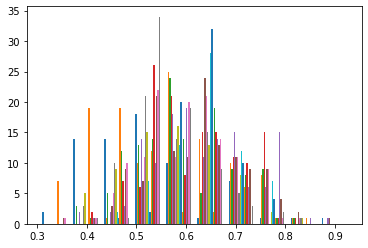

In [650]:
file = 'Content/markup/cossim/Tyva_rubert-tiny2_cossim.csv'
cs =    pd.read_csv (file, encoding ='utf-8')
rows = cs.iloc[:,2:].values
plt.hist(rows)

In [651]:
correct = cs.iloc[0,1]#.values
variants_cossim = cs.iloc[0,2:].values
strat_table = cs.columns
print (correct)

1


In [652]:
print (max(variants_cossim))
print (np.argmax(variants_cossim))

0.8945077781172548
0


0 - значит индекс +2. Т.е.

In [653]:
cs.iloc[0,2]

0.8945077781172548

In [654]:
strat_table[2]

'вводная часть '

In [655]:
cs.iloc[0,1]

1

In [656]:
np.sort (variants_cossim)

array([0.3682579825320051, 0.3730855899685356, 0.3809132484361788,
       0.3973666885884618, 0.4286349594007066, 0.4602319352901513,
       0.4678847942514226, 0.5026634690961149, 0.508374171067624,
       0.5183887293952696, 0.5207386145906097, 0.5313735237500904,
       0.5602260909598501, 0.5613214832502831, 0.582558931806034,
       0.6005995796640946, 0.8369842928651219, 0.8945077781172548],
      dtype=object)

СОВПАЛО

In [657]:
correct = cs.iloc[:,1].values
variants_cossim = cs.iloc[:,2:].values
answer_vec = np.argmax (variants_cossim, axis = 1)
answer_vec +=1
print (len(correct))
print (len(answer_vec))
print (np.mean(correct == answer_vec))

69
69
0.2028985507246377


In [658]:
answer_vec

array([ 1, 15,  1,  3,  4,  4,  4,  5,  7, 10, 10,  5,  6,  5,  9,  8,  6,
       10,  8,  7,  5,  6,  6, 10,  5, 11,  5,  9,  7, 14, 14, 10, 14, 16,
       14, 13, 16,  4, 11, 11, 15,  1, 11,  1,  1,  1,  5,  8, 11,  1, 11,
       18, 17,  4,  4,  6,  7, 15,  4,  6,  4,  4,  4,  3,  7,  4,  6,  5,
       18])

In [659]:
correct

array([ 1, 10, -1,  3,  4,  4,  4,  5, -1, -1, -1, -1, -1, -1, -1, -1,  6,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  9, -1, -1, -1, -1, 14, -1,
       -1, 13, 16,  2, -1, -1, 15, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, 17, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       18])

In [660]:
def check_acc(answer_vec, correct):
    acc = 0
    l = 0
    for i in range (len(correct)):
        if (correct[i]!= -1):
            l += 1
            if (correct[i] == answer_vec[i]):
                acc += 1
    return acc/l

In [661]:
check_acc(answer_vec, correct)

0.875

Т.е. если мы смотрим по всем ответам, по всему вектору оглавления, то точность 16%. А если только по тем позициям, по которым есть какое-то соответствие с оглавлением, то 69.
Как же обрабатывать -1?

Попробуем сейчас собрать по всем табличкам статистику.

In [662]:
path="Content/markup/cossim" #Подставить свой путь
files_cossim = files_list (path)
print (len(files_cossim))

Список файлов 

76


In [663]:
files_dict_cossim = {}
for name in names:
    files_dict_cossim[name] = []
    
for key in files_dict_cossim.keys():
    files_dict_cossim[key] = [s for s in files_cossim if key in s]

#Чтобы не попадали тини2 в тини
files_dict_cossim['rubert-tiny'] = [s for s in files_dict_cossim['rubert-tiny'] if 'rubert-tiny2' not in s]

print(files_dict_cossim['rubert-tiny'])

['Content/markup/cossim/Volgograd_rubert-tiny_cossim.csv', 'Content/markup/cossim/Voronezh_rubert-tiny_cossim.csv', 'Content/markup/cossim/Yakutia_rubert-tiny_cossim.csv', 'Content/markup/cossim/Tyva_rubert-tiny_cossim.csv', 'Content/markup/cossim/Udmurt_rubert-tiny_cossim.csv', 'Content/markup/cossim/Vologda_rubert-tiny_cossim.csv', 'Content/markup/cossim/Ulyanovsk_rubert-tiny_cossim.csv', 'Content/markup/cossim/Yaroslavl_rubert-tiny_cossim.csv', 'Content/markup/cossim/Yamalo-Nenets_rubert-tiny_cossim.csv', 'Content/markup/cossim/Adygeya_rubert-tiny_cossim.csv', 'Content/markup/cossim/Altai Resp_rubert-tiny_cossim.csv', 'Content/markup/cossim/Altai_rubert-tiny_cossim.csv', 'Content/markup/cossim/Amur_rubert-tiny_cossim.csv', 'Content/markup/cossim/Bryansk_rubert-tiny_cossim.csv', 'Content/markup/cossim/Bashkortastan_rubert-tiny_cossim.csv', 'Content/markup/cossim/Belgorod_rubert-tiny_cossim.csv', 'Content/markup/cossim/Vladimir_rubert-tiny_cossim.csv', 'Content/markup/cossim/Arkhangel

In [664]:
print(len(files_dict_cossim[names[0]]))
print(len(files_dict_cossim[names[1]]))
print(len(files_dict_cossim[names[2]]))
print(len(files_dict_cossim[names[3]]))

19
19
19
19


In [665]:
files_dict_cossim[names[3]]

['Content/markup/cossim/Volgograd_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Voronezh_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Yakutia_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Tyva_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Udmurt_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Vologda_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Ulyanovsk_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Yaroslavl_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Yamalo-Nenets_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Adygeya_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Altai Resp_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Altai_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Amur_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Bryansk_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Bashkortastan_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Belgorod_rubert-tiny2_cossim.csv',
 'Content/markup/cossim/Vladimir_rubert-tiny2_cossim.csv',

In [666]:
def make_metrics(filepath):
    cs =    pd.read_csv (filepath, encoding ='utf-8')
    correct = cs.iloc[:,1].values
    variants_cossim = cs.iloc[:,2:].values
    answer_vec = np.argmax (variants_cossim, axis = 1)
    answer_vec +=1
    #Общая точность
    acc_overall = np.mean(correct == answer_vec)
    acc_detailed = check_acc(answer_vec, correct)
    return acc_overall, acc_detailed

Соберём метрики по всем табличкам в два словарика. По всем строка и только по значимым

In [667]:
cossim_acc_all = {} 
cossim_acc_detailed = {}
for name in names:
    cossim_acc_detailed[name] = []
    cossim_acc_all[name] = []

for model_name, files in files_dict_cossim.items():
    tmp_metrics_all = []
    tmp_metrics_detailed = []
    
    print (model_name)
    print (files)
    for filepath in files:
        tmp_metrics_all.append(make_metrics(filepath)[0])
        tmp_metrics_detailed.append(make_metrics(filepath)[1])
    cossim_acc_all[model_name] = tmp_metrics_all
    cossim_acc_detailed[model_name] = tmp_metrics_detailed

rubert-tiny
['Content/markup/cossim/Volgograd_rubert-tiny_cossim.csv', 'Content/markup/cossim/Voronezh_rubert-tiny_cossim.csv', 'Content/markup/cossim/Yakutia_rubert-tiny_cossim.csv', 'Content/markup/cossim/Tyva_rubert-tiny_cossim.csv', 'Content/markup/cossim/Udmurt_rubert-tiny_cossim.csv', 'Content/markup/cossim/Vologda_rubert-tiny_cossim.csv', 'Content/markup/cossim/Ulyanovsk_rubert-tiny_cossim.csv', 'Content/markup/cossim/Yaroslavl_rubert-tiny_cossim.csv', 'Content/markup/cossim/Yamalo-Nenets_rubert-tiny_cossim.csv', 'Content/markup/cossim/Adygeya_rubert-tiny_cossim.csv', 'Content/markup/cossim/Altai Resp_rubert-tiny_cossim.csv', 'Content/markup/cossim/Altai_rubert-tiny_cossim.csv', 'Content/markup/cossim/Amur_rubert-tiny_cossim.csv', 'Content/markup/cossim/Bryansk_rubert-tiny_cossim.csv', 'Content/markup/cossim/Bashkortastan_rubert-tiny_cossim.csv', 'Content/markup/cossim/Belgorod_rubert-tiny_cossim.csv', 'Content/markup/cossim/Vladimir_rubert-tiny_cossim.csv', 'Content/markup/coss

In [668]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [669]:
cossim_acc_all[names[0]]

[0.19101123595505617,
 0.13793103448275862,
 0.06756756756756757,
 0.11594202898550725,
 0.2222222222222222,
 0.06521739130434782,
 0.09523809523809523,
 0.13114754098360656,
 0.14814814814814814,
 0.1875,
 0.14473684210526316,
 0.13559322033898305,
 0.06315789473684211,
 0.05339805825242718,
 0.13333333333333333,
 0.05357142857142857,
 0.13636363636363635,
 0.20689655172413793,
 0.11538461538461539]

<ipython-input-27-bdd3145c0e35>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cossim_acc.keys())


[Text(0, 0, 'rubert-tiny'),
 Text(1, 0, 'ruRoberta-large'),
 Text(2, 0, 'ruBert-base'),
 Text(3, 0, 'rubert-tiny2')]

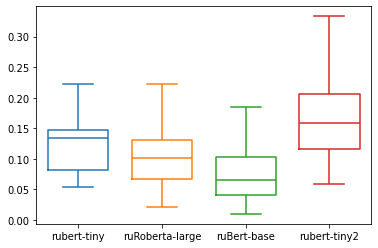

In [670]:
import seaborn as sns

data =    [cossim_acc_all[names[0]],
           cossim_acc_all[names[1]],
           cossim_acc_all[names[2]],
           cossim_acc_all[names[3]]]

ax = sns.boxplot(data=data, fill=False, gap=.1)
ax.set_xticklabels(cossim_acc.keys())


<ipython-input-28-c4de36357d69>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cossim_acc.keys())


[Text(0, 0, 'rubert-tiny'),
 Text(1, 0, 'ruRoberta-large'),
 Text(2, 0, 'ruBert-base'),
 Text(3, 0, 'rubert-tiny2')]

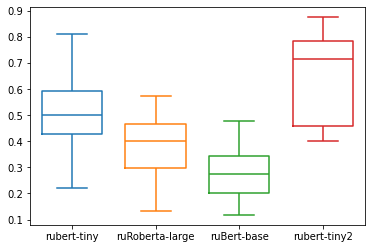

In [671]:
data =    [cossim_acc_detailed[names[0]],
           cossim_acc_detailed[names[1]],
           cossim_acc_detailed[names[2]],
           cossim_acc_detailed[names[3]]]

ax = sns.boxplot(data=data, fill=False, gap=.1)
ax.set_xticklabels(cossim_acc.keys())

Попробуем отсечь -1

In [672]:
def check_negative(filepath):
    cs =    pd.read_csv (filepath, encoding ='utf-8')
    cs = cs[cs['Эталон'] == -1]
    variants_cossim = cs.iloc[:,2:].values
    max_in_row = np.max (variants_cossim, axis = 1)
    min_in_row = np.min (variants_cossim, axis = 1)
    return variants_cossim, max_in_row, min_in_row

In [673]:
cossim_negative_min = {} 
cossim_negative_max = {} 
cossim_negative_values = {} 

for name in names:
    cossim_negative_min[name] = []
    cossim_negative_max[name] = []
    cossim_negative_values[name] = []
    
for model_name, files in files_dict_cossim.items():
    mins = []
    maxs = []
    variants = []
    
    print (model_name)
    print (files)
    for filepath in files:
        variants_cossim, max_in_row, min_in_row = check_negative(filepath)
        
        mins.append(min_in_row)
        maxs.append(max_in_row)
        variants.append(variants)

    cossim_negative_min[model_name] = mins
    cossim_negative_max[model_name] = maxs
    cossim_negative_values[model_name] = variants
    

rubert-tiny
['Content/markup/cossim/Volgograd_rubert-tiny_cossim.csv', 'Content/markup/cossim/Voronezh_rubert-tiny_cossim.csv', 'Content/markup/cossim/Yakutia_rubert-tiny_cossim.csv', 'Content/markup/cossim/Tyva_rubert-tiny_cossim.csv', 'Content/markup/cossim/Udmurt_rubert-tiny_cossim.csv', 'Content/markup/cossim/Vologda_rubert-tiny_cossim.csv', 'Content/markup/cossim/Ulyanovsk_rubert-tiny_cossim.csv', 'Content/markup/cossim/Yaroslavl_rubert-tiny_cossim.csv', 'Content/markup/cossim/Yamalo-Nenets_rubert-tiny_cossim.csv', 'Content/markup/cossim/Adygeya_rubert-tiny_cossim.csv', 'Content/markup/cossim/Altai Resp_rubert-tiny_cossim.csv', 'Content/markup/cossim/Altai_rubert-tiny_cossim.csv', 'Content/markup/cossim/Amur_rubert-tiny_cossim.csv', 'Content/markup/cossim/Bryansk_rubert-tiny_cossim.csv', 'Content/markup/cossim/Bashkortastan_rubert-tiny_cossim.csv', 'Content/markup/cossim/Belgorod_rubert-tiny_cossim.csv', 'Content/markup/cossim/Vladimir_rubert-tiny_cossim.csv', 'Content/markup/coss

In [674]:
#cossim_negative_values[names[0]][0][0][0]

Как распределены минимумы?

<ipython-input-1-73819883a74e>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys)


[Text(0, 0, 'tiny_min'),
 Text(1, 0, 'tiny_max'),
 Text(2, 0, 'large_min'),
 Text(3, 0, 'large_max'),
 Text(4, 0, 'base_min'),
 Text(5, 0, 'base_max'),
 Text(6, 0, 'tiny2_min'),
 Text(7, 0, 'tiny2_max')]

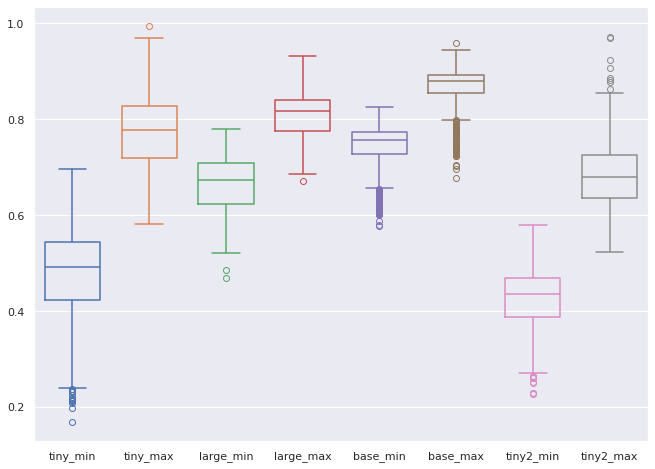

In [675]:
data =    [np.hstack(cossim_negative_min[names[0]]),
           np.hstack(cossim_negative_max[names[0]]),
           np.hstack(cossim_negative_min[names[1]]),
           np.hstack(cossim_negative_max[names[1]]),
           np.hstack(cossim_negative_min[names[2]]),
           np.hstack(cossim_negative_max[names[2]]),
           np.hstack(cossim_negative_min[names[3]]),
           np.hstack(cossim_negative_max[names[3]])]



sns.set(rc={'figure.figsize':(11,8)})
ax = sns.boxplot(data=data, fill=False, gap=.1)
keys = ['tiny_min','tiny_max','large_min','large_max','base_min','base_max','tiny2_min','tiny2_max']
ax.set_xticklabels(keys)


Берём тини2. 

In [676]:
data_min = np.hstack(cossim_negative_min[names[3]])
data_max = np.hstack(cossim_negative_max[names[3]])

print (max(data_min), min(data_max))

0.5802818674628087 0.5227136482134491


In [677]:
print (len(data_min[data_min>min(data_max)]))

45


В общем, вот нам и граничное значение для отнесения строки к -1. Ошибёмся на 62 сравнениях. Из примерно $18*20*30$ сравнений.

Наверное, ошибочное мы можем руками перепроверить. Так что пускай будет меньше отнесено к -1 - к незначимым строкам. 
Тогда наше граничное значение - минимальное значение от максимума (серая нижняя точка на боксплоте, у самого правого)

In [335]:

#TODO выбор граничного значения по разметке
#TODO создание табличек, где по выбранному значению по неразмеченным табличкам делается оглавление





## Посчитаем косинусное расстояние по оставшимся неразмеченным на тини2

In [690]:
path="Content/tables" #Подставить свой путь
files = []
files = files_list (path)
print (len(files))

Список файлов 

221


In [691]:
name = names[3]
model = models[name]
tokenizer = tokenizers[name]
toc_process(model = model, tokenizer = tokenizer, file = "Content/markup/Etalon.csv", encoding='utf-8', model_name=name, dirr = 'tables')

Exists: Content/tables/vectors/Etalon_rubert-tiny2.csv


In [694]:
files_s = [s for s in files if "Etalon" not in s]
files_s = [s for s in files_s if "labeled" not in s]
files_s = [s for s in files_s if "vectors" not in s]
files_s = [s for s in files_s if "cossim" not in s]
len(files_s)

73

In [695]:
files_s

['Content/tables/Amur.csv',
 'Content/tables/Arkhangelsk.csv',
 'Content/tables/Astrakhan.csv',
 'Content/tables/Belgorod.csv',
 'Content/tables/Adygeya.csv',
 'Content/tables/Altai Resp.csv',
 'Content/tables/Bashkortastan.csv',
 'Content/tables/Bryansk.csv',
 'Content/tables/Buryatia.csv',
 'Content/tables/Chelyabinsk.csv',
 'Content/tables/Chechen.csv',
 'Content/tables/Chuvash.csv',
 'Content/tables/Crimea.csv',
 'Content/tables/Daghestan.csv',
 'Content/tables/Ingushetia.csv',
 'Content/tables/Irkutsk.csv',
 'Content/tables/Ivanovo.csv',
 'Content/tables/Jewish.csv',
 'Content/tables/Kabardian-Balkar.csv',
 'Content/tables/Kaliningrad.csv',
 'Content/tables/Kalmykia.csv',
 'Content/tables/Kaluga.csv',
 'Content/tables/Kamchatka.csv',
 'Content/tables/Karachaev-Circassian.csv',
 'Content/tables/Karelia.csv',
 'Content/tables/Kemerovo.csv',
 'Content/tables/Khabarovsk.csv',
 'Content/tables/Khakassia.csv',
 'Content/tables/Khanty-Mansi.csv',
 'Content/tables/Kirov.csv',
 'Content/ta

In [696]:
from pathlib import Path
def toc_process_strats_nonlabel(model, tokenizer, file = "Amursk.csv",  encoding='utf-8', model_name='tiny_bert', dirr = 'markup'):
    filemane = file.split('/')[-1].split('.')[0]
    csv_name = "Content/"+ dirr + "/vectors/" + filemane + '_'+ model_name + '.csv'
    s = Path(csv_name)
    if not s.exists():
        my_cols = ['Текст']
        df = pd.read_csv(file,
                        sep=";",
                        encoding=encoding,
                        names=my_cols,
                        header=None,
                        engine="python")

        set_random_seed(42)

        features_po_tiny = []
        for index, row in df.iterrows():
            emb = embed_bert_cls(row["Текст"], model, tokenizer, model_name)
            features_po_tiny.append(emb)

        df = pd.DataFrame((np.hstack([df, np.array(features_po_tiny)])))
        for i in range(len(df.index)):
            #df.loc[i, 'vec'] = np.array(df.loc[i, 2:(len(df.columns)-2):1])
            df.loc[i, 'vec'] = ','.join (map(str, df.loc[i, 1:])) #Пропускаем первые 2 столбца с текстом и разметкой
        df_fin = pd.DataFrame(np.vstack([df[0], df['vec']]).T, columns=['Текст', 'Вектор'])

        #print (df_fin.columns)
        df_fin.to_csv(csv_name, index=False)
        print (csv_name)

        return df_fin
    else:
        print ('Exists:', csv_name)

In [697]:
print (name)
for strat in files_s:
    toc_process_strats_nonlabel(model = model, tokenizer = tokenizer, file = strat, encoding='utf-8', model_name=name, dirr = 'tables')

rubert-tiny2
Exists: Content/tables/vectors/Amur_rubert-tiny2.csv
Exists: Content/tables/vectors/Arkhangelsk_rubert-tiny2.csv
Exists: Content/tables/vectors/Astrakhan_rubert-tiny2.csv
Exists: Content/tables/vectors/Belgorod_rubert-tiny2.csv
Exists: Content/tables/vectors/Adygeya_rubert-tiny2.csv
Exists: Content/tables/vectors/Altai Resp_rubert-tiny2.csv
Exists: Content/tables/vectors/Bashkortastan_rubert-tiny2.csv
Exists: Content/tables/vectors/Bryansk_rubert-tiny2.csv
Exists: Content/tables/vectors/Buryatia_rubert-tiny2.csv
Exists: Content/tables/vectors/Chelyabinsk_rubert-tiny2.csv
Exists: Content/tables/vectors/Chechen_rubert-tiny2.csv
Exists: Content/tables/vectors/Chuvash_rubert-tiny2.csv
Exists: Content/tables/vectors/Crimea_rubert-tiny2.csv
Exists: Content/tables/vectors/Daghestan_rubert-tiny2.csv
Exists: Content/tables/vectors/Ingushetia_rubert-tiny2.csv
Exists: Content/tables/vectors/Irkutsk_rubert-tiny2.csv
Exists: Content/tables/vectors/Ivanovo_rubert-tiny2.csv
Exists: Conte

In [726]:
import glob
import os


def files_list (path):
    files = []
    print ('Список файлов \n')
    for r, d, f in os.walk(path):
        for file in f:
            if file.endswith(('.csv')):
                files.append (os.path.join(r, file))
                #print(os.path.join(r, file))
    return files


path="Content/tables" #Подставить свой путь
files_vect = files_list (path)

Список файлов 



In [718]:
%ls

Content/
Обработка_оглавления_v1_1.ipynb


In [729]:
path="Content/tables/" #Подставить свой путь
files_sv = files_list (path)
print (len(files_sv))

Список файлов 

147


In [ ]:
files_s = [s for s in files_sv if "Etalon" not in s]
files_e = [s for s in files_sv if "Etalon" in s]

print (len(files_e))
print ((files_e))
print (len(files_s))

In [703]:
def makecossim_nonlabel(strat, ethalon):
    filename = strat.split('/')[-1].split('.')[0]
    csv_name = "Content/tables/cossim/" + filename + '_cossim.csv'
    #print (csv_name)
    s = Path(csv_name)
    if not s.exists():
        strat =    pd.read_csv (strat, encoding ='utf-8')
        ethalon =  pd.read_csv (ethalon, encoding='utf-8')
        
        for index_s, row_s in strat.iterrows():
            for index_e, row_e in ethalon.iterrows():
                #Делаем вектора из строк. Это костыль, ибо мы сохраняли в pandas вектора в виде строк в 1 ячейку (чтобы не учитывать разные длины векторов)
                list_e = row_e['Вектор'].split(',')
                list_s = row_s['Вектор'].split(',')

                vec_e = list(map(float,list_e))
                vec_s = list(map(float,list_s))

                #косталь - у части строк последнее значение nan
                vec_e = [x for x in vec_e if str(x) != 'nan']
                vec_s = [x for x in vec_s if str(x) != 'nan']

                strat.loc[index_s, row_e['Текст']] = cos_sim(vec_s, vec_e)
        
        df = strat.drop('Вектор',axis = 1)#Тут он нам уже лишний
        df.to_csv(csv_name, index=False)
        print (csv_name)

                
    else:
        print ('Exists:', csv_name)

In [704]:
et = files_e[0]

for st in files_s:
    print (st)
    makecossim_nonlabel(strat = st, ethalon = et)


Content/tables/vectors/Amur_rubert-tiny2.csv
Exists: Content/tables/cossim/Amur_rubert-tiny2_cossim.csv
Content/tables/vectors/Arkhangelsk_rubert-tiny2.csv
Exists: Content/tables/cossim/Arkhangelsk_rubert-tiny2_cossim.csv
Content/tables/vectors/Astrakhan_rubert-tiny2.csv
Exists: Content/tables/cossim/Astrakhan_rubert-tiny2_cossim.csv
Content/tables/vectors/Belgorod_rubert-tiny2.csv
Exists: Content/tables/cossim/Belgorod_rubert-tiny2_cossim.csv
Content/tables/vectors/Adygeya_rubert-tiny2.csv
Exists: Content/tables/cossim/Adygeya_rubert-tiny2_cossim.csv
Content/tables/vectors/Altai Resp_rubert-tiny2.csv
Exists: Content/tables/cossim/Altai Resp_rubert-tiny2_cossim.csv
Content/tables/vectors/Bashkortastan_rubert-tiny2.csv
Exists: Content/tables/cossim/Bashkortastan_rubert-tiny2_cossim.csv
Content/tables/vectors/Bryansk_rubert-tiny2.csv
Exists: Content/tables/cossim/Bryansk_rubert-tiny2_cossim.csv
Content/tables/vectors/Buryatia_rubert-tiny2.csv
Exists: Content/tables/cossim/Buryatia_rubert

In [770]:
path="Content/tables/cossim" #Подставить свой путь
files_cossim = files_list (path)
print(len(files_cossim))

Список файлов 

73


In [796]:
df_stats_of_strats = pd.DataFrame([], columns = ['Регион', 'Длина','Класс -1', 'Не хватает', 'Пункты, которых нет', 'Пункты, которые есть']) 

In [797]:
df_stats_of_strats

,Регион,Длина,Класс -1,Не хватает


In [810]:
df_stats_of_strats = pd.DataFrame([], columns = ['Регион', 'Длина','Класс -1', 'Не хватает', 'Пункты, которых нет', 'Есть','Пункты, которые есть']) 
for f_path in files_cossim:
    cs =    pd.read_csv (f_path, encoding ='utf-8')
    vect = cs[cs.apply(lambda row: all(float(column) < 0.52 for column in row[1:]), axis=1)].index.values
    cs_columns = cs.columns[1:]
    
    variants_cossim = cs.iloc[:,1:].values
    answer_vec = np.argmax (variants_cossim, axis = 1)
    
    etalon_names = cs_columns[answer_vec]

    cs['class'] = answer_vec
    cs.loc[vect, 'class'] = -1
    
    reg_name = f_path.split('/')[-1].split('_')[0]
    minus_count = len(vect)
    table_len = len(cs)
    
    difference = set(list(range(0,18))) - set(answer_vec)#(set(answer_vec)).difference(set(list(range(1,19)))) #set(answer_vec) - set(list(range(1,19)))
    #print (set(answer_vec))
    print (difference)
    
    existing_ind = set(list(range(0,18))) & set(answer_vec)
    
    #none_punkts =  ','.join(cs_columns[difference])
    none_punkts =  '; '.join(cs_columns[list(difference)])
    existing_punkts =  '; '.join(cs_columns[list(existing_ind)])
    
    
    new_row = {'Регион':reg_name, 'Длина':table_len, 'Класс -1':minus_count, 'Не хватает':difference, 'Пункты, которых нет':none_punkts, 'Есть':existing_ind,  'Пункты, которые есть': existing_punkts}
    df_stats_of_strats = df_stats_of_strats.append(new_row, ignore_index=True)
    
    cs_to_save = pd.DataFrame((np.vstack([cs['Текст'], cs['class'], etalon_names])).T, columns=['Текст','Класс в Эталоне','Эталон'])
    fin_path = 'Content/tables/answers/'+reg_name + '_ans.csv'
    cs_to_save.to_csv(fin_path, index=False)
    
    print(reg_name)

df_stats_of_strats.to_csv('Content/tables/answers/strat_stats.csv', index=False)

{16, 11}
Altai Resp
{16, 13, 11, 5}
Altai
{11}
Amur
{2, 3, 4, 5, 7, 8, 11, 12}
Arkhangelsk
{13, 14, 15}
Astrakhan
{8, 11, 7}
Bashkortastan
{11, 12}
Belgorod
{11, 15}
Buryatia
{13}
Chechen
{13, 4, 12}
Chelyabinsk
{6, 10, 11, 12, 13, 15, 16}
Chuvash
{2, 4, 11, 12, 13, 15, 16}
Crimea
{1, 11, 13}
Daghestan
{2, 4, 6, 7, 9, 10, 11, 12, 16}
Ingushetia
{1, 2, 6, 11, 14, 16}
Irkutsk
{0, 11, 15, 16, 17}
Ivanovo
{16, 11, 13}
Jewish
{8, 10, 11, 12, 13, 16}
Kabardian-Balkar
{1, 2, 3, 4, 5, 7, 11, 12, 13, 15, 16}
Kaliningrad
{11, 13}
Kalmykia
{4, 5, 7, 10, 11, 13, 16}
Kaluga
{11, 15}
Kamchatka
{1, 2, 5, 11, 14, 16}
Karachaev-Circassian
{1, 6, 8, 11, 13, 16}
Karelia
{16, 11}
Khabarovsk
{11}
Khakassia
{1, 3, 10, 11, 13, 14, 16}
Khanty-Mansi
{8, 16, 11, 6}
Kirov
{11}
Komi
{1, 2, 3, 4, 5, 7, 8, 12, 13, 15}
Kostroma
{16, 1, 11, 6}
Krasnodar
{8, 16, 12, 13}
Krasnoyarsk
{2, 11}
Kurgan
{11}
Kursk
{1, 3, 11, 13, 16}
Leningrad
{1, 3, 4, 5, 9, 11, 13}
Lipetsk
{8, 11, 13, 6}
Magadan
{16}
Mariy El
{16, 11, 7}
Mo

<ipython-input-26-5f500da25fc9>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stats_of_strats = df_stats_of_strats.append(new_row, ignore_index=True)
<ipython-input-26-5f500da25fc9>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stats_of_strats = df_stats_of_strats.append(new_row, ignore_index=True)
<ipython-input-26-5f500da25fc9>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stats_of_strats = df_stats_of_strats.append(new_row, ignore_index=True)
<ipython-input-26-5f500da25fc9>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stats_of_strats = df_stats_of_strats.append(new_row, ignore_index=True)
<ipython-input-2

In [762]:
file = 'Content/tables/cossim/Altai_rubert-tiny2_cossim.csv'
cs =    pd.read_csv (file, encoding ='utf-8')
cs.head(2)

,Текст,Вводная часть,Оценка достигнутых целей социально-экономиечского развития,"Приоритеты, цели и задачи социально-экономического развития",Целевой сценарий социально-экономического развития,Основные направления развития человеческого капитала и социальной сферы,Основные направления экономического развития,Основные направления развития научно-инновационной сферы,Основные направления рационального природопользования и обеспечения экологической безопасности,Основные направления развития межрегиональных и внешнеэкономических связей,Основные направления пространственного развития,Сведения о кадровом обеспечении экономики,Заключительная часть,"Оценка финансовых ресурсов, необходимых для реализации стратегии",Сроки и этапы реализации стратегии,Пприложение с основными показателями достижения целей социально-экономического развития,Приложение с ожидаемыми результатами реализации стратегии,Приложение с перечнем крупных инвестиционных проектов,Приложение с государственными программи
0,1. Общие положения,0.659481,0.503554,0.493380,0.528382,0.480804,0.542985,0.479830,0.476649,0.426595,0.599523,0.584795,0.631322,0.488034,0.511701,0.531913,0.535275,0.454968,0.559657
1,1.1. Оценка основных итогов реализации стратег...,0.394828,0.727024,0.646909,0.690854,0.639580,0.678736,0.620603,0.588943,0.606059,0.616570,0.613301,0.383712,0.646402,0.611228,0.748843,0.660164,0.540666,0.506038


In [764]:
new_df

,Текст,Вводная часть,Оценка достигнутых целей социально-экономиечского развития,"Приоритеты, цели и задачи социально-экономического развития",Целевой сценарий социально-экономического развития,Основные направления развития человеческого капитала и социальной сферы,Основные направления экономического развития,Основные направления развития научно-инновационной сферы,Основные направления рационального природопользования и обеспечения экологической безопасности,Основные направления развития межрегиональных и внешнеэкономических связей,Основные направления пространственного развития,Сведения о кадровом обеспечении экономики,Заключительная часть,"Оценка финансовых ресурсов, необходимых для реализации стратегии",Сроки и этапы реализации стратегии,Пприложение с основными показателями достижения целей социально-экономического развития,Приложение с ожидаемыми результатами реализации стратегии,Приложение с перечнем крупных инвестиционных проектов,Приложение с государственными программи
37,4. Институциональное и ресурсное обеспечение р...,0.556969,0.668725,0.614208,0.619463,0.649038,0.577005,0.641977,0.651489,0.602941,0.642185,0.655833,0.507161,0.675710,0.620343,0.640521,0.610862,0.600088,0.586793
41,4.1.3. Экспортная стратегия,0.610869,0.563985,0.523937,0.618850,0.520312,0.643798,0.568752,0.512694,0.564661,0.629943,0.588288,0.544072,0.600000,0.652575,0.594696,0.696849,0.578420,0.580865
54,Инвестиционная стратегия,0.614080,0.650264,0.573009,0.744183,0.577850,0.716412,0.611873,0.561799,0.597004,0.662322,0.706643,0.553820,0.772245,0.728705,0.645692,0.737514,0.705235,0.640849


In [765]:
vect = new_df.index.values
vect

array([37, 41, 54])

In [772]:
len(vect), len (cs)

(3, 59)

In [768]:
variants_cossim = cs.iloc[:,1:].values
answer_vec = np.argmax (variants_cossim, axis = 1)

cs['class'] = answer_vec
cs.loc[vect, 'class'] = -1

In [769]:
cs

,Текст,Вводная часть,Оценка достигнутых целей социально-экономиечского развития,"Приоритеты, цели и задачи социально-экономического развития",Целевой сценарий социально-экономического развития,Основные направления развития человеческого капитала и социальной сферы,Основные направления экономического развития,Основные направления развития научно-инновационной сферы,Основные направления рационального природопользования и обеспечения экологической безопасности,Основные направления развития межрегиональных и внешнеэкономических связей,Основные направления пространственного развития,Сведения о кадровом обеспечении экономики,Заключительная часть,"Оценка финансовых ресурсов, необходимых для реализации стратегии",Сроки и этапы реализации стратегии,Пприложение с основными показателями достижения целей социально-экономического развития,Приложение с ожидаемыми результатами реализации стратегии,Приложение с перечнем крупных инвестиционных проектов,Приложение с государственными программи,class
0,1. Общие положения,0.659481,0.503554,0.493380,0.528382,0.480804,0.542985,0.479830,0.476649,0.426595,0.599523,0.584795,0.631322,0.488034,0.511701,0.531913,0.535275,0.454968,0.559657,0
1,1.1. Оценка основных итогов реализации стратег...,0.394828,0.727024,0.646909,0.690854,0.639580,0.678736,0.620603,0.588943,0.606059,0.616570,0.613301,0.383712,0.646402,0.611228,0.748843,0.660164,0.540666,0.506038,14
2,1.2. Оценка социально-экономического потенциал...,0.391094,0.743553,0.656437,0.699354,0.664507,0.652209,0.620722,0.570171,0.588910,0.601753,0.649049,0.366175,0.582138,0.481141,0.720144,0.538242,0.479998,0.479163,1
3,1.2.1. Природно-ресурсный потенциал,0.527695,0.594819,0.544793,0.578008,0.585274,0.556085,0.626051,0.600336,0.501047,0.624107,0.604793,0.458247,0.553115,0.451709,0.586462,0.523923,0.498759,0.551971,6
4,1.2.2. Демографический потенциал,0.564356,0.550992,0.491318,0.559660,0.544051,0.545796,0.565504,0.461830,0.476345,0.604313,0.600711,0.526029,0.527027,0.443578,0.555578,0.536558,0.486033,0.527628,9
5,1.2.3. Инфраструктурный потенциал,0.593078,0.596684,0.527347,0.593248,0.585428,0.590599,0.634629,0.537322,0.544156,0.650378,0.630384,0.549275,0.545387,0.493075,0.599090,0.569161,0.538880,0.544324,9
6,1.2.4. Экономический потенциал,0.539182,0.653510,0.586012,0.648811,0.587124,0.670990,0.589018,0.527089,0.553038,0.623396,0.672725,0.510202,0.612269,0.489211,0.650781,0.556982,0.534329,0.521278,10
7,1.2.5. Туристско-рекреационный потенциал,0.535452,0.616562,0.559937,0.620002,0.592885,0.641827,0.656948,0.602177,0.622677,0.674404,0.628416,0.484911,0.562622,0.515605,0.625878,0.539756,0.570023,0.549350,9
8,1.2.6. Экспортный потенциал,0.621274,0.576046,0.521056,0.574226,0.547571,0.608023,0.580585,0.464645,0.541345,0.614954,0.595850,0.564045,0.522924,0.495986,0.606602,0.578690,0.566502,0.535962,0
9,1.3. Место и роль Алтайского края в реализации...,0.383762,0.677431,0.756299,0.672115,0.738156,0.719715,0.680884,0.651115,0.680649,0.683670,0.595376,0.360015,0.568241,0.564810,0.750385,0.550451,0.527237,0.517343,2


In [753]:
cs.loc[vect, 'class'] = -1

In [754]:
cs

,Текст,Вводная часть,Оценка достигнутых целей социально-экономиечского развития,"Приоритеты, цели и задачи социально-экономического развития",Целевой сценарий социально-экономического развития,Основные направления развития человеческого капитала и социальной сферы,Основные направления экономического развития,Основные направления развития научно-инновационной сферы,Основные направления рационального природопользования и обеспечения экологической безопасности,Основные направления развития межрегиональных и внешнеэкономических связей,Основные направления пространственного развития,Сведения о кадровом обеспечении экономики,Заключительная часть,"Оценка финансовых ресурсов, необходимых для реализации стратегии",Сроки и этапы реализации стратегии,Пприложение с основными показателями достижения целей социально-экономического развития,Приложение с ожидаемыми результатами реализации стратегии,Приложение с перечнем крупных инвестиционных проектов,Приложение с государственными программи,class
0,1. Общие положения,0.659481,0.503554,0.493380,0.528382,0.480804,0.542985,0.479830,0.476649,0.426595,0.599523,0.584795,0.631322,0.488034,0.511701,0.531913,0.535275,0.454968,0.559657,0.0
1,1.1. Оценка основных итогов реализации стратег...,0.394828,0.727024,0.646909,0.690854,0.639580,0.678736,0.620603,0.588943,0.606059,0.616570,0.613301,0.383712,0.646402,0.611228,0.748843,0.660164,0.540666,0.506038,0.0
2,1.2. Оценка социально-экономического потенциал...,0.391094,0.743553,0.656437,0.699354,0.664507,0.652209,0.620722,0.570171,0.588910,0.601753,0.649049,0.366175,0.582138,0.481141,0.720144,0.538242,0.479998,0.479163,0.0
3,1.2.1. Природно-ресурсный потенциал,0.527695,0.594819,0.544793,0.578008,0.585274,0.556085,0.626051,0.600336,0.501047,0.624107,0.604793,0.458247,0.553115,0.451709,0.586462,0.523923,0.498759,0.551971,0.0
4,1.2.2. Демографический потенциал,0.564356,0.550992,0.491318,0.559660,0.544051,0.545796,0.565504,0.461830,0.476345,0.604313,0.600711,0.526029,0.527027,0.443578,0.555578,0.536558,0.486033,0.527628,0.0
5,1.2.3. Инфраструктурный потенциал,0.593078,0.596684,0.527347,0.593248,0.585428,0.590599,0.634629,0.537322,0.544156,0.650378,0.630384,0.549275,0.545387,0.493075,0.599090,0.569161,0.538880,0.544324,0.0
6,1.2.4. Экономический потенциал,0.539182,0.653510,0.586012,0.648811,0.587124,0.670990,0.589018,0.527089,0.553038,0.623396,0.672725,0.510202,0.612269,0.489211,0.650781,0.556982,0.534329,0.521278,0.0
7,1.2.5. Туристско-рекреационный потенциал,0.535452,0.616562,0.559937,0.620002,0.592885,0.641827,0.656948,0.602177,0.622677,0.674404,0.628416,0.484911,0.562622,0.515605,0.625878,0.539756,0.570023,0.549350,0.0
8,1.2.6. Экспортный потенциал,0.621274,0.576046,0.521056,0.574226,0.547571,0.608023,0.580585,0.464645,0.541345,0.614954,0.595850,0.564045,0.522924,0.495986,0.606602,0.578690,0.566502,0.535962,0.0
9,1.3. Место и роль Алтайского края в реализации...,0.383762,0.677431,0.756299,0.672115,0.738156,0.719715,0.680884,0.651115,0.680649,0.683670,0.595376,0.360015,0.568241,0.564810,0.750385,0.550451,0.527237,0.517343,0.0


In [ ]:
def replace(x):
    return x.replace('foo', 'wow')

cs.apply(np.vectorize(foo_bar))
cs